In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
df1 = pd.read_csv(r'GOOG.csv')
df2 = pd.read_csv(r'AMZN.csv')
df3= pd.read_csv(r'^NSEI.csv')
df1['company']='GOOG'
df2['company']='AMZN'
df3['company']='NSEI'

In [3]:
df=pd.concat([df1,df2,df3])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company
0,2015-01-01,26.378078,26.490770,24.914099,24.986401,24.986401,169447946,GOOG
1,2015-01-08,24.831326,25.176876,24.311253,24.974932,24.974932,247158716,GOOG
2,2015-01-15,25.209288,25.892912,24.819857,25.831081,25.831081,190297030,GOOG
3,2015-01-22,26.002609,27.034277,25.430182,25.430182,25.430182,201804538,GOOG
4,2015-01-29,25.480045,26.919592,24.991386,26.066435,26.066435,326897039,GOOG


In [4]:
df.shape

(1313, 8)

In [5]:
df['Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d')

In [6]:


train = df[df['Date']<'2019-01-01']
test = df[df['Date']>='2019-01-01']

In [7]:

df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999885,0.999814,0.999687,0.999687,-0.638794
High,0.999885,1.000000,0.999816,0.999854,0.999854,-0.638860
Low,0.999814,0.999816,1.000000,0.999876,0.999876,-0.638849
Close,0.999687,0.999854,0.999876,1.000000,1.000000,-0.638666
Adj Close,0.999687,0.999854,0.999876,1.000000,1.000000,-0.638666
Volume,-0.638794,-0.638860,-0.638849,-0.638666,-0.638666,1.000000


LSTM MODEL

In [10]:
def modelLSTM(x_train ,y_train,x_test,mms):
  model = Sequential()
  model.add(LSTM(units = 13, input_shape = (x_train.shape[1],1),return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=13))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))
  model.compile(optimizer = 'adam' , loss = 'mean_squared_error')
  train = model.fit(x_train, y_train, epochs = 30, batch_size = 10, validation_split=0.20,verbose=0)
  y_predict=model.predict(x_test)
  y_predict=mms.inverse_transform(y_predict)
  return y_predict

8/8 [==============================] - 0s 1ms/step
0.9666234942354077


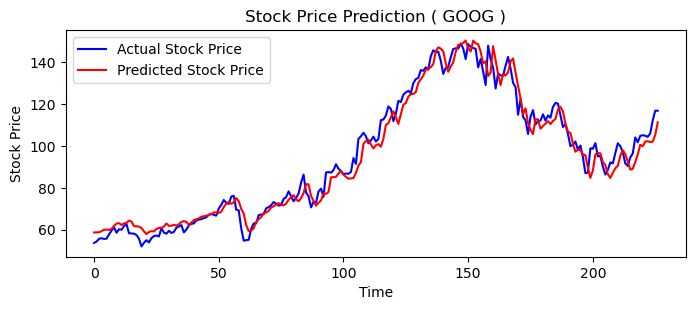

8/8 [==============================] - 0s 1ms/step
0.9082528547967939


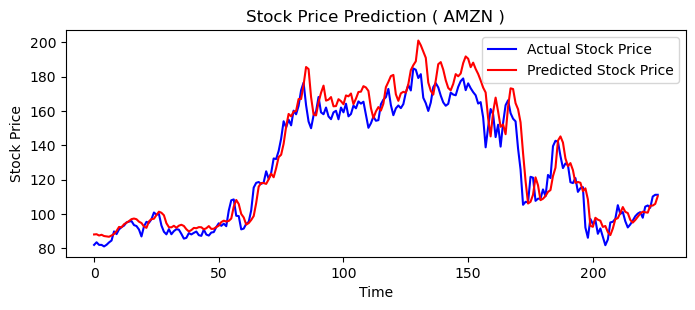

8/8 [==============================] - 0s 1ms/step
0.9723118824895262


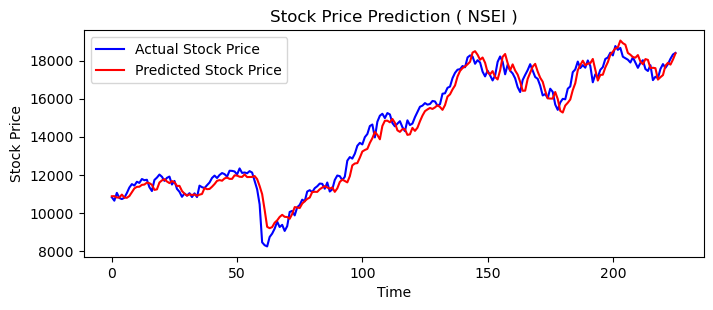

In [11]:
for j,company in enumerate(train['company'].unique()):
  x_train=[]
  y_train=[]
  t=train[train['company']==company]
  mms = MinMaxScaler()
  train_set = t[['Adj Close']]
  train_set_scaled = mms.fit_transform(train_set)
  N = len(train_set_scaled)
  batch=2
  for i in range ( batch , N):
    x_train.append(train_set_scaled[i-batch:i,0])
    y_train.append(train_set_scaled[i,0])

  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
  test_set = test[test['company']==company]
  test_set=test_set[['Adj Close']]
  mms2 = MinMaxScaler()
  test_scaled = mms2.fit_transform(test_set)
  y_test=test_set[batch:]
  y_test=y_test.reset_index()
  x_test =[]
  M = len(test_set)
  for i in range (2,M):
    x_test.append(test_scaled[i-2:i,0])
  x_test=np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
  y_predict= modelLSTM(x_train,y_train,x_test,mms2)
  y_true = np.array(y_test)
  y_true = y_true[:,1]
  y_predict
  print(r2_score(y_true, y_predict[:,0]))
  plt.figure(figsize=(8, 10))
  plt.subplot(3,1,j+1)
  plt.plot(y_test['Adj Close'], color = 'blue', label = 'Actual Stock Price')
  plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction ( '+company+' )')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

LAST VALUE MODEL

0.992157363696669


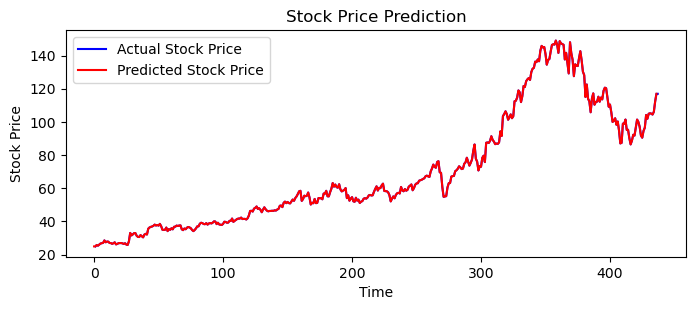

0.9911669362375297


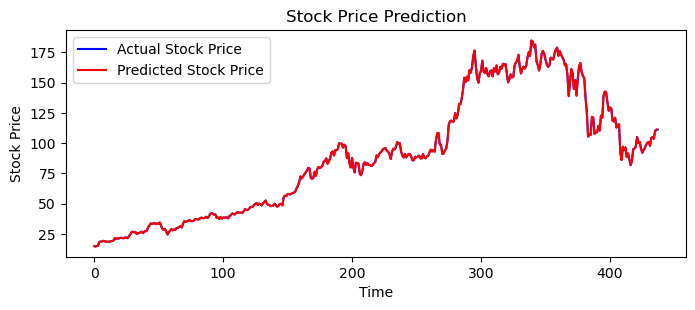

0.9939544754494056


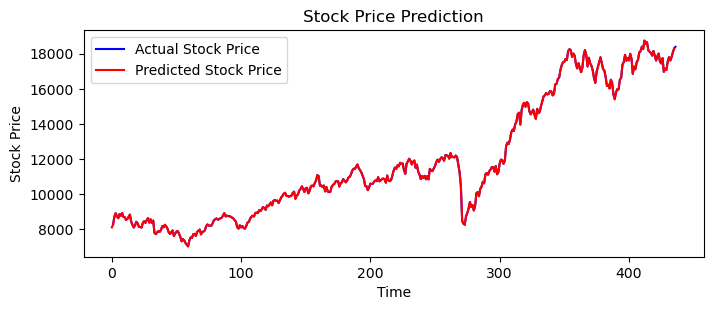

In [12]:
for i,company in enumerate(df['company'].unique()):
  y_predict=df[df['company']==company]['Adj Close'][:-1]
  y_true =df[df['company']==company]['Adj Close'][1:]
  print(r2_score(y_true, y_predict))
  plt.figure(figsize=(8, 10))
  plt.subplot(3,1,i+1)
  plt.plot(y_true, color = 'blue', label = 'Actual Stock Price')
  plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

MOVING AVERAGE 

1313
0.9907801922356237


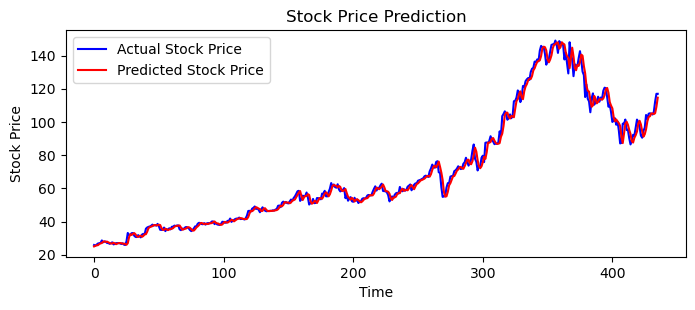

1313
0.9885287777714662


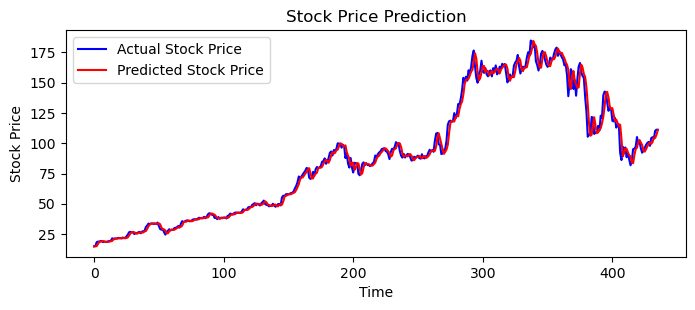

1313
0.9919915511089875


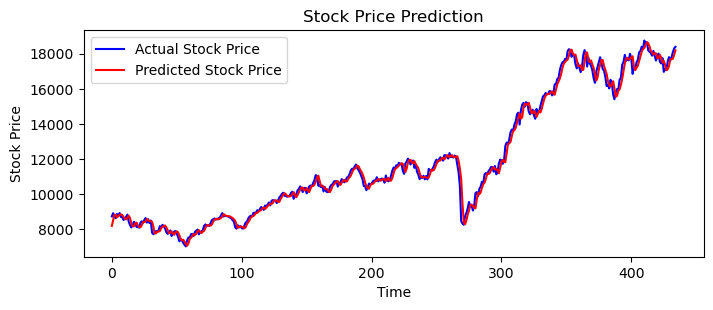

In [13]:
for i,company in enumerate(df['company'].unique()):
  N=2
  print(len(df))
  y_predict=[]
  y_true=[]
  for j in range(N,len(df[df['company']==company])):
    y_predict.append(sum(df[df['company']==company]['Adj Close'][j-N:j])/2)
    y_true.append(df[df['company']==company]['Adj Close'][j])
  print(r2_score(y_true, y_predict))
  plt.figure(figsize=(8, 10))
  plt.subplot(3,1,i+1)
  plt.plot(y_true, color = 'blue', label = 'Actual Stock Price')
  plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

LINEAR REGRESSION

0.9799145989443877


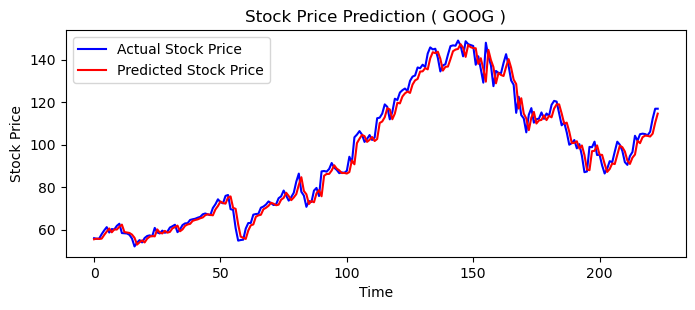

0.963630859939001


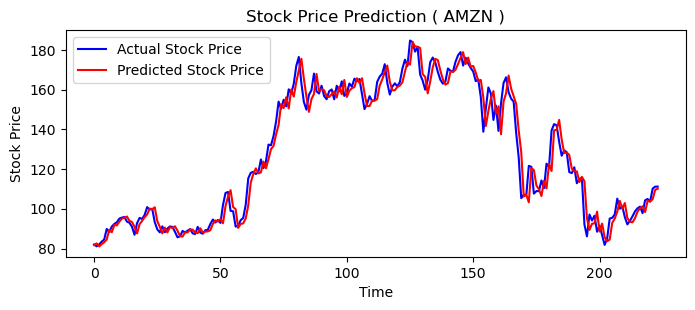

0.9871514571340231


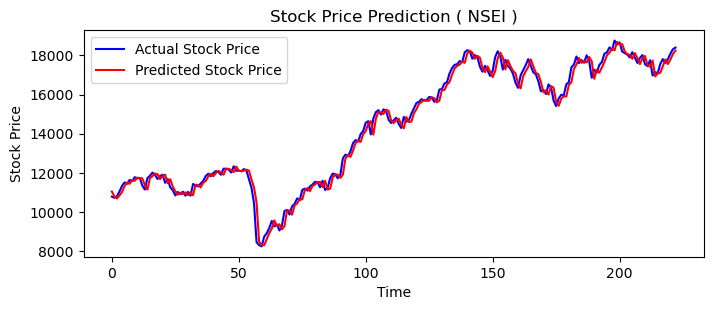

In [14]:
from sklearn.linear_model import LinearRegression
for j,company in enumerate(train['company'].unique()):
  x_train=[]
  y_train=[]
  train_set=train[train['company']==company]['Adj Close']
  N = len(train_set)
  batch = 5
  for i in range( batch , N):
    x_train.append(train_set[i-batch:i])
    y_train.append(train_set[i])
  reg = LinearRegression().fit(x_train,y_train)
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  reg = LinearRegression().fit(x_train, y_train)
  #print(x_train.shape)
  #print(y_train.shape)
  test_set=test[test['company']==company]['Adj Close']
  y_test=test_set[batch:]
  y_test=y_test.reset_index()
  y_true=y_test['Adj Close']
  x_test =[]
  M = len(test_set)
  for i in range (batch,M):
    x_test.append(test_set[i-batch:i])
  x_test=np.array(x_test)
  y_predict = reg.predict(x_test)
  print(r2_score(y_true, y_predict))
  plt.figure(figsize=(8, 10))
  plt.subplot(3,1,j+1)
  plt.plot(y_true, color = 'blue', label = 'Actual Stock Price')
  plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction ( '+company+' )')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()

XGBOOST 

0.9696165008923213


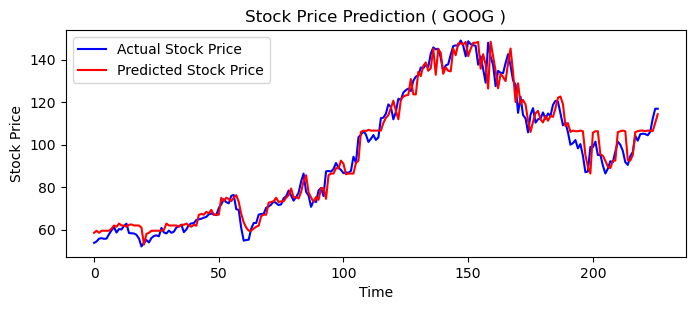

0.9551065993399336


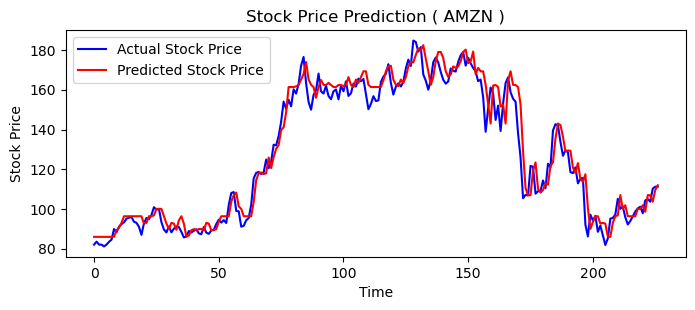

0.9790324200918515


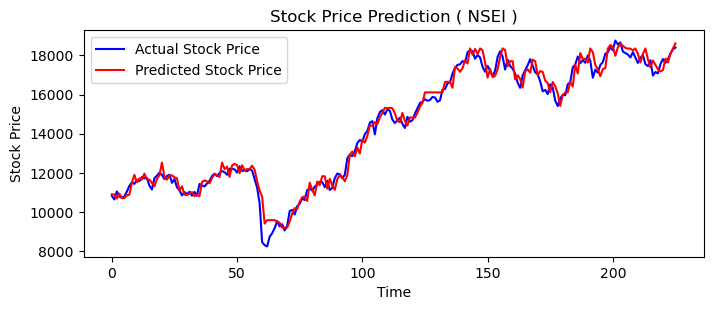

In [25]:
from xgboost import XGBRegressor


for j,company in enumerate(train['company'].unique()):
  x_train=[]
  y_train=[]
  ss= StandardScaler()

  model = XGBRegressor(max_depth= 10,
                       n_estimators= 1000,seed=42,gamma= 0.01,
                       learning_rate= 0.01)
  train_set=train[train['company']==company]
  train_set=train_set[['Adj Close']]
  train_set_scaled = ss.fit_transform(train_set)
  N = len(train_set)
  batch = 2
  for i in range( batch , N):
    x_train.append(train_set_scaled[i-batch:i,0])
    y_train.append(train_set_scaled[i,0])
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  model.fit(x_train, y_train)
  test_set=test[test['company']==company]['Adj Close']
  y_test=test_set[batch:]
  test_set=test[test['company']==company]
  test_set=test_set[['Adj Close']]
  
  y_test=y_test.reset_index()
  y_true=y_test['Adj Close']
  x_test =[]
  M = len(test_set)
  ss2=StandardScaler()
  test_set_scaled=ss2.fit_transform(test_set)
  for i in range (batch,M):
    x_test.append(test_set_scaled[i-batch:i,0])
  x_test=np.array(x_test)
  y_predict = model.predict(x_test).reshape(-1,1)
  #print(y_predict)
  y_predict=ss2.inverse_transform(y_predict)
  print(r2_score(y_predict,y_true))
  plt.figure(figsize=(8, 10))
  plt.subplot(3,1,j+1)
  plt.plot(y_true, color = 'blue', label = 'Actual Stock Price')
  plt.plot(y_predict, color = 'red', label = 'Predicted Stock Price')
  plt.title('Stock Price Prediction ( '+company+' )')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()
  plt.show()